<a href="https://colab.research.google.com/github/hamzafarooq/time_series/blob/master/UsingPycaret_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import imageio
import os
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt


2.3.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Read Data


In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')



Authenticated


In [3]:
%%bigquery --project bold-sorter-281506 df2
SELECT *
FROM `bigquery-public-data.iowa_liquor_sales.sales`
where store_number  = '2633'
and date > '2018-01-01'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#df2 = pd.read_csv('/content/drive/My Drive/data/store_2633.csv')

In [4]:
df2.head(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-28154300054,2020-06-22,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1012300,Single Malt Scotch,266,Edrington Group USA LLC,5486,Macallan 12YR,12,750,40.01,60.02,60,3601.20,45.0,11.88
1,INV-25345500055,2020-02-20,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1012300,Single Malt Scotch,266,Edrington Group USA LLC,5486,Macallan 12YR,12,750,40.01,60.02,60,3601.20,45.0,11.88
2,INV-16050800003,2018-12-03,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1022300,Mezcal,368,Park Street Imports,989504,Ilegal Mezcal Reposado,6,750,30.34,45.51,18,819.18,13.5,3.56
3,INV-21584400001,2019-08-29,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1901200,Special Order Items,497,Fredrick Wildman & Son,902536,Chartreuse Yellow,12,750,31.13,46.70,24,1120.80,18.0,4.75
4,INV-21460600008,2019-08-26,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1012300,Single Malt Scotch,266,Edrington Group USA LLC,5486,Macallan 12 Yr Single Malt Scotch,12,750,34.99,52.49,60,3149.40,45.0,11.88


In [5]:
df2_ds = df2[['date','sale_dollars']]


In [6]:
df2_ds=df2_ds.sort_index(axis=0)

In [7]:
df2_ds.tail(5)

,date,sale_dollars
50522,2019-12-09,1379.88
50523,2019-11-25,148.50
50524,2019-10-24,119.28
50525,2019-10-17,119.28
50526,2019-10-21,279.00


In [178]:
aggregated=df2_ds.groupby('date',as_index=True).sum()

In [179]:
aggregated.tail(5)

,sale_dollars
date,
2020-07-21,22054.44
2020-07-23,79001.99
2020-07-27,59207.67
2020-07-28,1905.24
2020-07-30,117104.75


In [180]:
aggregated.index=pd.to_datetime(aggregated.index)

#Create Fetaures

In [176]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['flag'] = pd.Series(np.where(df['date'] >= np.datetime64('2020-03-03'), 1, 0), index=df.index)
    #df['rolling_mean_7'] = df['sale_dollars'].shift(7).rolling(window=7).mean()
    #df['lag_7'] = df['sale_dollars'].shift(7)
    #df['lag_15']=df['sale_dollars'].shift(15)
    #df['lag_last_year']=df['sale_dollars'].shift(52).rolling(window=15).mean()
  
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','flag','sale_dollars']]
    X.index=df.index
    return X

In [177]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

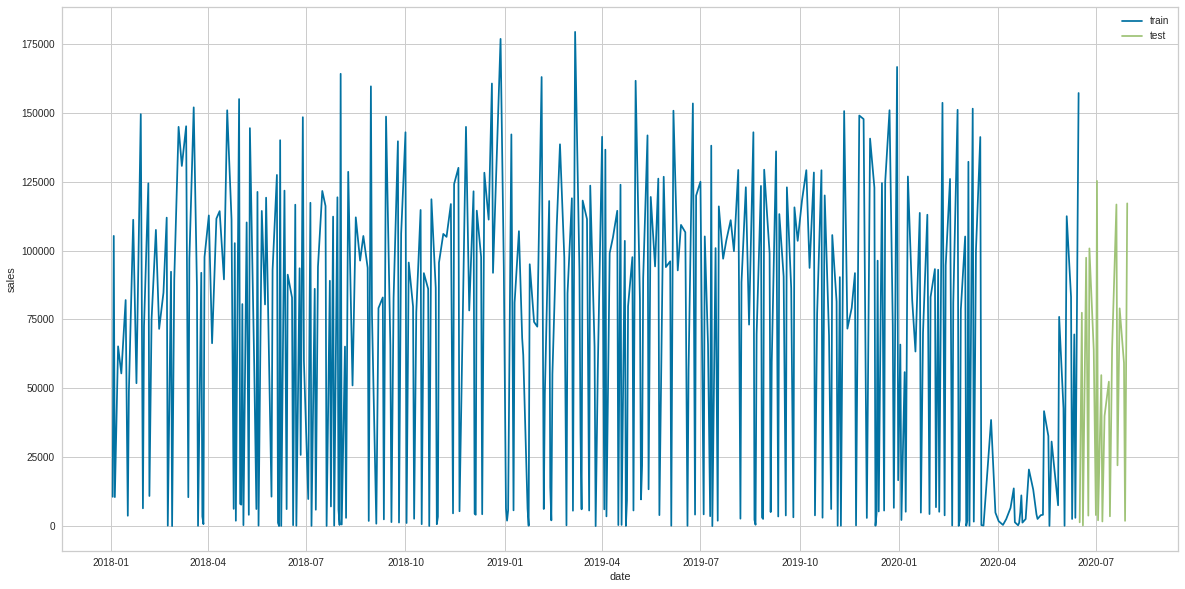

In [246]:
aggregated=create_features(aggregated)
train, test = split_data(aggregated, '2020-06-15')

plt.figure(figsize=(20,10))
plt.xlabel('date')
plt.ylabel('sales')
plt.plot(train.index,train['sale_dollars'],label='train')
plt.plot(test.index,test['sale_dollars'],label='test')
plt.legend()
plt.show()


In [247]:
train.tail(4)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,flag,sale_dollars
date,,,,,,,,,
2020-06-09,1,2,6,2020,161,9,24,1,2588.94
2020-06-11,3,2,6,2020,163,11,24,1,69550.07
2020-06-12,4,2,6,2020,164,12,24,1,3011.43
2020-06-15,0,2,6,2020,167,15,25,1,157158.24


# Run PyCaret

In [248]:
#!pip install pycaret

In [249]:
from pycaret.regression import *

In [323]:
reg = setup(data = train, 
             target = 'sale_dollars',
             numeric_imputation = 'mean',
             categorical_features = ['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear',
                                     'flag']  , 
            normalize = True, transformation = True, transform_target = True, 
                  combine_rare_levels = True, rare_level_threshold = 0.1,
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95,
             silent = True)

 
Setup Succesfully Completed.


,Description,Value
0,session_id,2927
1,Transform Target,True
2,Transform Target Method,yeo-johnson
3,Original Data,"(385, 9)"
4,Missing Values,False
5,Numeric Features,0
6,Categorical Features,8
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [206]:
# return best model
top3 = compare_models(n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Light Gradient Boosting Machine,22686.3826,998199592.7256,31085.2230,0.6277,1.7618,35.9326,0.0281
1,Random Forest,20627.4170,1036362408.0806,31323.6236,0.6112,1.3250,8.4323,0.4825
2,Extreme Gradient Boosting,23576.3960,1068494839.5553,32074.1424,0.5997,1.6854,32.0353,0.2167
3,Huber Regressor,23998.6184,1089975693.4287,32520.3259,0.5911,1.6243,25.3330,0.1142
4,Bayesian Ridge,25233.7591,1090220468.3120,32691.6003,0.5902,1.7142,34.3396,0.2148
5,CatBoost Regressor,23596.4509,1099383092.1949,32601.8867,0.5880,1.6832,30.8476,1.4661
6,Gradient Boosting Regressor,23671.0760,1124019242.2340,32787.4344,0.5776,1.6721,31.1431,0.1449
7,Ridge Regression,25610.9480,1156682906.4561,33676.5696,0.5641,1.6960,33.1279,0.0113
8,Passive Aggressive Regressor,27294.7063,1192216928.2732,34168.1735,0.5551,1.8510,44.7237,0.4750
9,AdaBoost Regressor,27455.7249,1235009552.6769,34884.3571,0.5387,1.9161,49.7993,0.0734


In [324]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,17486.5188,1316118812.7703,36278.3518,0.5735,1.7528,17.2176
1,26609.1977,1674557218.0807,40921.3541,0.3623,2.0521,12.9995
2,24755.4273,1605713011.6854,40071.3490,0.4510,2.0242,7.6710
3,17405.8343,715680975.9361,26752.2144,0.7691,1.0186,2.3190
4,20478.1391,728201659.0991,26985.2119,0.7159,1.0769,1.7815
5,23798.4458,1025084289.6036,32016.9375,0.6867,1.3147,3.6910
6,25318.6352,1272138681.9004,35667.0532,0.5258,2.0233,4.8183
7,27895.8593,1600284506.7584,40003.5562,0.5360,1.6094,10.2194
8,19321.3791,944895515.8600,30739.1528,0.5954,1.7590,14.2425
9,22869.3750,822404214.4126,28677.5908,0.5728,0.6769,0.7201


In [325]:
#%tb
tuned_lightgbm = tune_model(lightgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,17275.7366,1320713887.9337,36341.6275,0.5721,1.7795,19.8295
1,26792.2755,1554828602.8400,39431.3150,0.4079,2.0129,13.3544
2,25162.0842,1521852200.1857,39010.9241,0.4796,1.8205,11.7185
3,20831.5704,918218176.6272,30302.1151,0.7038,1.1320,3.3920
4,15616.4694,547001734.7059,23388.0682,0.7866,1.1230,2.6346
5,27718.5083,1336924351.8252,36563.9761,0.5913,1.2373,4.2502
6,26832.6822,1325360556.8573,36405.5017,0.5060,2.0058,3.7870
7,28680.3511,1895398063.5864,43536.1696,0.4505,1.6439,11.6222
8,16011.1151,764352053.6389,27646.9176,0.6727,1.8021,18.0479
9,22639.8447,851014859.9620,29172.1590,0.5579,0.7266,0.7913


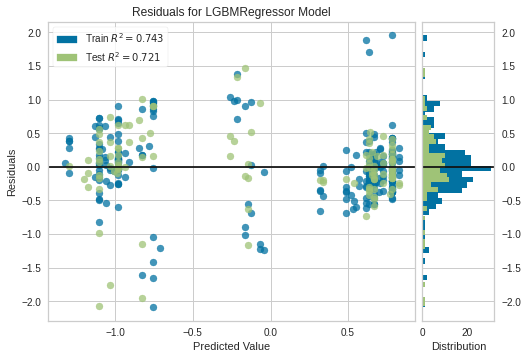

In [326]:
plot_model(tuned_lightgbm)

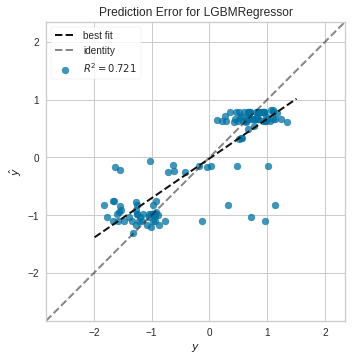

In [327]:
plot_model(tuned_lightgbm, plot = 'error')

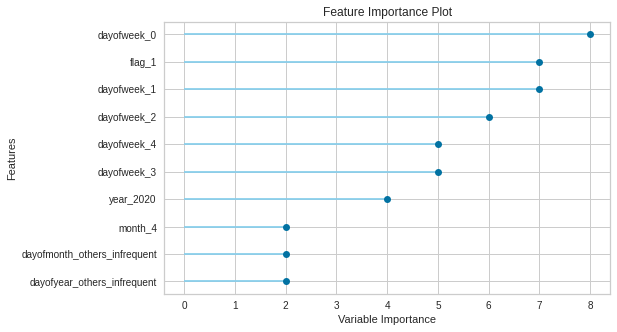

In [328]:
plot_model(tuned_lightgbm, plot='feature')

In [329]:
predict_model(tuned_lightgbm);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,19314.465,9.756865e+08,31235.9813,0.6633,1.5108,0 13.150665 dtype: float64


In [330]:
final_lightgbm = finalize_model(tuned_lightgbm)

In [331]:
#Final Light Gradient Boosting Machine parameters for deployment
print(final_lightgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.2, max_depth=20,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.3,
              n_estimators=90, n_jobs=-1, num_leaves=20, objective=None,
              random_state=2927, reg_alpha=0.6, reg_lambda=0.1, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [332]:
predict_model(final_lightgbm);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,18406.9134,9.335951e+08,30554.788,0.6779,1.4633,0 12.519468 dtype: float64


In [333]:
unseen_predictions = predict_model(final_lightgbm, data=test)
unseen_predictions.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,flag,sale_dollars,Label
0,1,2,6,2020,168,16,25,1,1376.22,3839.3983
1,3,2,6,2020,170,18,25,1,77424.58,32710.7883
2,4,2,6,2020,171,19,25,1,226.68,7054.8449
3,0,2,6,2020,174,22,26,1,97385.87,35173.8741
4,2,2,6,2020,176,24,26,1,3810.90,4950.3307


In [334]:
def plot_series(time, series,i, format="-", start=0, end=None):
    #plt.figure(figsize=(20,10))
    plt.plot(time[start:end], series[start:end], format,label=i)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()

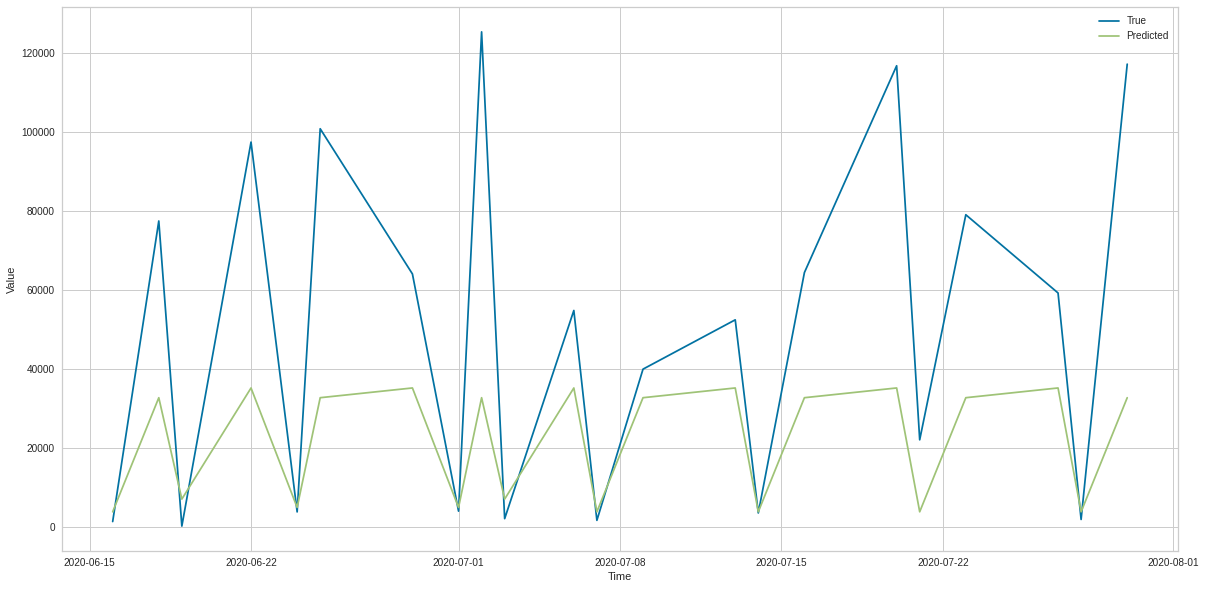

In [335]:
plt.figure(figsize=(20,10))
plot_series(test.index, test['sale_dollars'],"True")
#plot_series(train['ds'],train['y'])
plot_series(test.index, unseen_predictions['Label'],"Predicted")

In [336]:
huber = create_model('huber', verbose = False)
rf = create_model('rf', verbose = False)
lightgbm = create_model('lightgbm', verbose = False)
ridge = create_model('ridge', verbose = False)

In [337]:
tuned_rf = tune_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,15453.7071,1226059059.8863,35015.1262,0.6027,1.6361,22.8205
1,26368.5144,1685617459.7872,41056.2719,0.3581,1.9108,8.5998
2,22294.3946,1432884467.4698,37853.4604,0.5101,1.8223,6.0170
3,16488.3417,701865828.4440,26492.7505,0.7736,1.2545,5.2372
4,15101.9106,460620600.8662,21462.0735,0.8203,1.3025,2.6504
5,28525.0833,1423203144.8767,37725.3647,0.5650,1.1056,1.8547
6,26246.0230,1254491992.5564,35418.8085,0.5324,1.9035,3.0369
7,25782.4186,1710301522.2241,41355.7919,0.5041,1.4350,6.7188
8,15568.3408,828448631.8387,28782.7836,0.6453,1.6689,16.7581
9,23747.9651,954846883.2194,30900.5968,0.5040,0.8188,1.1211


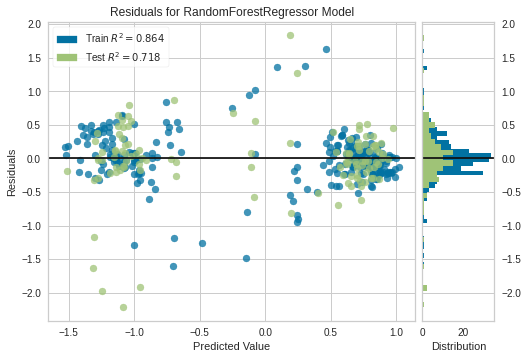

In [338]:
plot_model(tuned_rf)

In [339]:
xgb=create_model('xgboost')
tuned_xbb= tune_model(xgb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,19157.1672,1389753084.7128,37279.3922,0.5497,1.6838,31.7928
1,31397.5453,2329295090.9909,48262.7713,0.1130,1.9810,7.9340
2,24487.0629,1657940267.4818,40717.8127,0.4331,2.4513,4.2319
3,14145.1704,491007557.8199,22158.6903,0.8416,1.1798,3.3530
4,19637.9121,689394803.1679,26256.3288,0.7310,1.4846,2.3070
5,28221.5799,1484049450.5221,38523.3624,0.5464,1.2393,4.0709
6,29343.9412,1406464971.2914,37502.8662,0.4757,1.9363,3.9596
7,22738.8416,1376901018.1453,37106.6169,0.6008,1.2120,3.4116
8,20977.2641,1349813105.0131,36739.8027,0.4220,1.5122,10.1012
9,30317.2870,1632107292.3057,40399.3477,0.1521,0.7160,0.6271


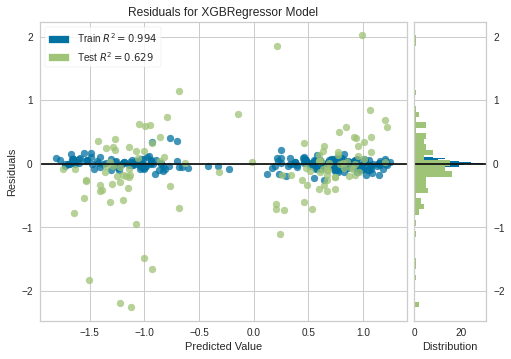

In [340]:
plot_model(tuned_xbb)

In [341]:
blend_specific = blend_models(estimator_list = [tuned_rf,dt,tuned_lightgbm,tuned_xbb])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,16538.2706,1330748346.0612,36479.4236,0.5688,1.6560,20.2704
1,27246.4834,1715456413.3190,41418.0687,0.3467,1.9783,11.0350
2,23394.5133,1486325000.7813,38552.8858,0.4918,1.8523,5.0704
3,15829.3938,693244770.5407,26329.5418,0.7764,1.0098,2.1860
4,14503.4533,450433334.0641,21223.4148,0.8242,1.3015,2.4366
5,26237.6855,1226069403.2355,35015.2739,0.6252,1.1162,1.9184
6,24577.1693,1067231342.2456,32668.5069,0.6022,1.8531,1.9340
7,25174.1766,1485731641.1295,38545.1896,0.5693,1.5192,12.0424
8,18749.1517,945214458.5499,30744.3403,0.5953,1.5579,9.6187
9,23819.5133,970953833.1982,31160.1321,0.4956,0.6420,0.6647


In [342]:
predict_model(blend_specific);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,20091.1533,1.074017e+09,32772.2015,0.6294,1.4308,0 11.273639 dtype: float64


In [343]:
final_model = finalize_model(blend_specific)

In [344]:
unseen_predictions_2 = predict_model(final_model, data=test, round=0)
unseen_predictions_2.loc[unseen_predictions_2['Label'] < 0, 'Label'] = 0
unseen_predictions_2.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,flag,sale_dollars,Label
0,1,2,6,2020,168,16,25,1,1376.22,5954.0
1,3,2,6,2020,170,18,25,1,77424.58,55874.0
2,4,2,6,2020,171,19,25,1,226.68,7973.0
3,0,2,6,2020,174,22,26,1,97385.87,58838.0
4,2,2,6,2020,176,24,26,1,3810.90,6636.0


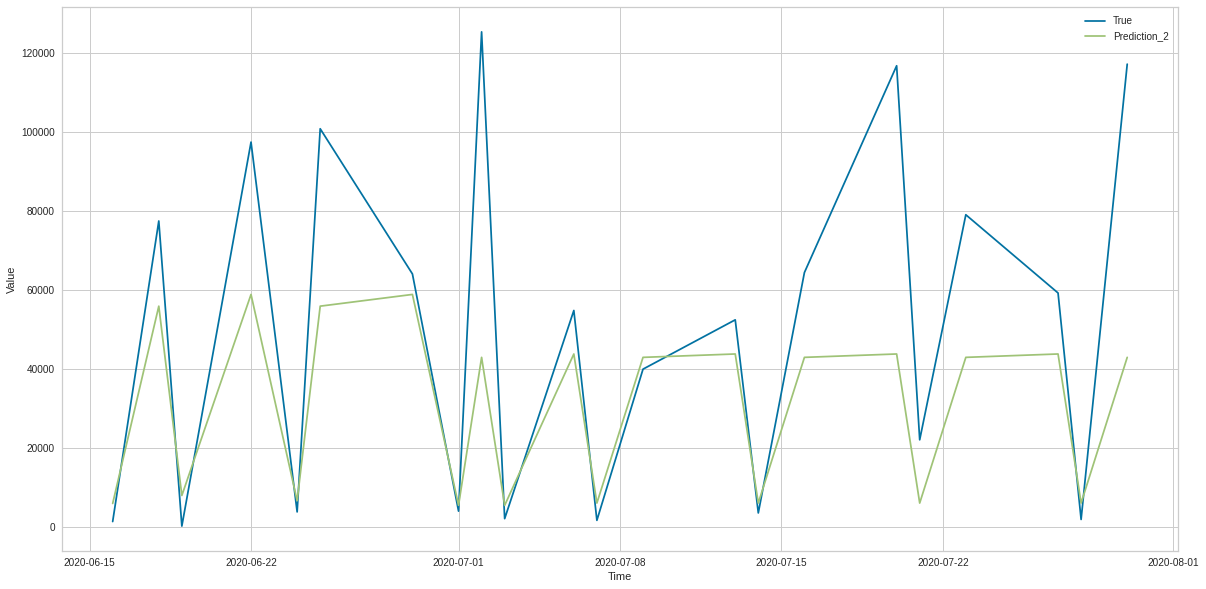

In [345]:
plt.figure(figsize=(20,10))
plot_series(test.index, test['sale_dollars'],"True")
#plot_series(train['ds'],train['y'])
#plot_series(X_test.index, unseen_predictions['Label'],'Prediction_1')
plot_series(test.index, unseen_predictions_2['Label'],'Prediction_2')


In [346]:
stack_1 = stack_models([tuned_rf,tuned_xbb, tuned_lightgbm])
predict_model(stack_1);
final_stack_1 = finalize_model(stack_1)
unseen_predictions_3 = predict_model(final_stack_1, data=test, round=0)


In [347]:
def calc_smape(y_hat, y):
        return 100/len(y) * np.sum(2 * np.abs(y_hat - y) / (np.abs(y) + np.abs(y_hat)))

In [348]:
calc_smape(test['sale_dollars'].values,unseen_predictions['Label'].values)

77.5131395866915

In [349]:
calc_smape(test['sale_dollars'].values,unseen_predictions_2['Label'].values)

67.11265129390662

In [350]:
calc_smape(test['sale_dollars'].values,unseen_predictions_3['Label'].values)

130.17337377570843